In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import shap

C:\Users\Anish Kumar Verma\PycharmProjects\HOML\.venv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

df = pd.read_csv('Byte2Beat/Data/Cardiac Failure/cardiac_failure_processed.csv', delimiter=',')
df = df.drop(columns=["Unnamed: 0", 'id'])

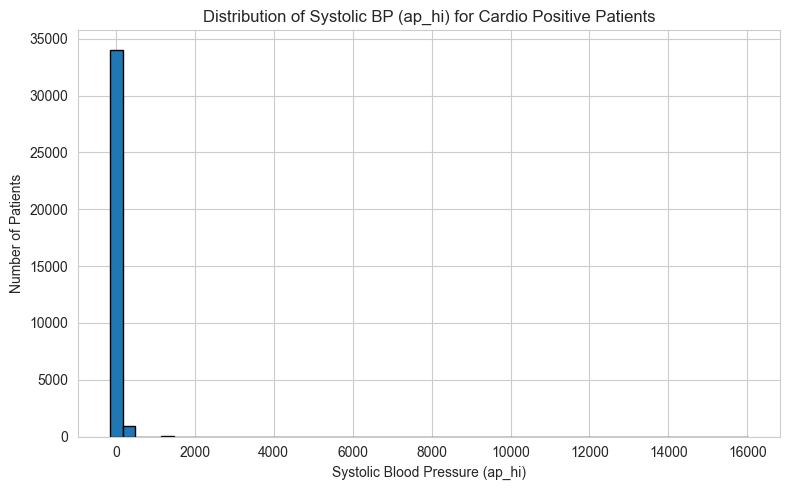

In [3]:
plt.figure(figsize=(8, 5))
plt.hist(
    df[df['cardio']==1]["ap_hi"],
    bins=50,
    edgecolor="black"
)

plt.xlabel("Systolic Blood Pressure (ap_hi)")
plt.ylabel("Number of Patients")
plt.title("Distribution of Systolic BP (ap_hi) for Cardio Positive Patients")
plt.tight_layout()
plt.show()

In [4]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0.588076,2,168,62.0,110,80,1,1,0,0,1,0
1,0.730159,1,156,85.0,140,90,3,1,0,0,1,1
2,0.624003,1,165,64.0,130,70,3,1,0,0,0,1
3,0.528455,2,169,82.0,150,100,1,1,0,0,1,1
4,0.516918,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
df.shape

(70000, 12)

In [6]:

df['gender'] = df['gender'] - 1
df["cholesterol"] = (df["cholesterol"] - 1) / 2
df["bmi"] = df["weight"] / ((df["height"] / 100) ** 2)

In [7]:

cols_to_trim = ["ap_hi", 'height', 'weight']
for col in cols_to_trim:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

In [8]:

lower = df["ap_lo"].quantile(0.01)
upper = df["ap_lo"].quantile(0.98)
df["ap_lo"] = df["ap_lo"].clip(lower, upper)

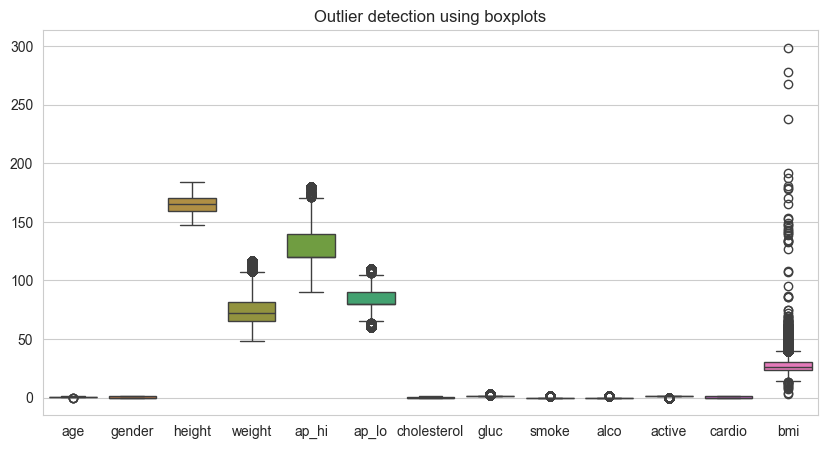

In [9]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df)
plt.title("Outlier detection using boxplots")
plt.show()

In [10]:

X = df.drop(columns=["cardio"])
y = df["cardio"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [11]:
numeric_cols = [
    "age",
    "height",
    "weight",
    "ap_hi",
    "ap_lo",
    "bmi"
]

binary_cols = [
    "gender",
    "cholesterol",
    "gluc",
    "smoke",
    "alco",
    "active"
]


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), numeric_cols),
        ("bin", "passthrough", binary_cols)
    ]
)


In [13]:
# A comprehensive grid designed for a ~2 hour run time
param_grid_stage1 = {
    "model__max_depth": [3, 4, 5, 6],

    "model__min_child_weight": [10, 15],

    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__n_estimators": [200, 300,400]
}


In [14]:

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42
    ))
])


In [15]:
from sklearn.model_selection import GridSearchCV

grid1 = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_stage1,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid1.fit(X, y)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         RobustScaler(),
                                                                         ['age',
                                                                          'height',
                                                                          'weight',
                                                                          'ap_hi',
                                                                          'ap_lo',
                                                                          'bmi']),
                                                                        ('bin',
                                                                         'passthrough',
                                                                         ['gender',
                                                                          'cholesterol',
                                                                          'gluc',
                                                                          'smoke',
                                                                          'alco',
                                                                          'active'])])),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=N...
                                                      max_depth=6,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=300,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 4, 5, 6],
                         'model__min_child_weight': [10, 15],
                         'model__n_estimators': [200, 300, 400]},
             scoring='recall', verbose=2)

In [16]:
print("Best Recall:", grid1.best_score_)
print("Best params:")
for k, v in grid1.best_params_.items():
    print(f"  {k}: {v}")


Best Recall: 0.6988192047656355
Best params:
  model__learning_rate: 0.05
  model__max_depth: 6
  model__min_child_weight: 10
  model__n_estimators: 400


In [17]:
best_structure_params = grid1.best_params_
pipeline.set_params(**best_structure_params)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['age', 'height', 'weight',
                                                   'ap_hi', 'ap_lo', 'bmi']),
                                                 ('bin', 'passthrough',
                                                  ['gender', 'cholesterol',
                                                   'gluc', 'smoke', 'alco',
                                                   'active'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, dev...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [18]:
final_model=grid1.best_estimator_


In [19]:
final_model.named_steps["model"].get_params()


{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': 10,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 400,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [20]:

y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7523571428571428


In [21]:

y_prob = final_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)

ROC-AUC: 0.8289266278127765


In [22]:
from sklearn.metrics import confusion_matrix, recall_score

for t in [0.25, 0.3, 0.35, 0.4, 0.45]:
    y_pred_t = (y_prob >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred_t)
    recall = recall_score(y_test, y_pred_t)
    fn = cm[1, 0]
    fp = cm[0, 1]
    print(
        f"t={t:.2f} | Recall={recall:.3f} | FN={fn} | FP={fp}"
    )


t=0.25 | Recall=0.936 | FN=448 | FP=4262
t=0.30 | Recall=0.894 | FN=740 | FP=3431
t=0.35 | Recall=0.854 | FN=1019 | FP=2821
t=0.40 | Recall=0.800 | FN=1397 | FP=2250
t=0.45 | Recall=0.761 | FN=1671 | FP=1830


In [23]:
THRESHOLD = 0.35
y_pred_final = (y_prob >= THRESHOLD).astype(int)


In [24]:

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_final))
print(confusion_matrix(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.80      0.60      0.69      7004
           1       0.68      0.85      0.76      6996

    accuracy                           0.73     14000
   macro avg       0.74      0.73      0.72     14000
weighted avg       0.74      0.73      0.72     14000

[[4183 2821]
 [1019 5977]]


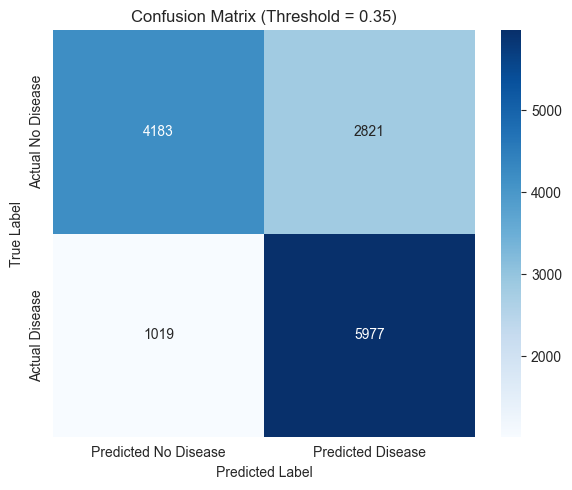

In [25]:
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted No Disease", "Predicted Disease"],
    yticklabels=["Actual No Disease", "Actual Disease"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Threshold = 0.35)")
plt.tight_layout()
plt.show()


In [26]:

print("Train accuracy:", final_model.score(X_train, y_train))
print("Test accuracy:", final_model.score(X_test, y_test))

Train accuracy: 0.7561428571428571
Test accuracy: 0.7523571428571428


In [27]:
from sklearn.metrics import roc_auc_score

y_prob = final_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)


ROC-AUC: 0.8289266278127765


Accuracy (threshold=0.35): 0.7140

ROC-AUC (probability-based): ~0.81


#further analysis

In [28]:
xgb_model = final_model.named_steps["model"]


In [29]:
all_feature_names = df.drop(columns=["cardio"]).columns.tolist()


In [30]:

importance = xgb_model.get_booster().get_score(importance_type="gain")

importance_df = (
    pd.DataFrame.from_dict(importance, orient="index", columns=["gain"])
    .reset_index()
    .rename(columns={"index": "feature"})
)


In [31]:
importance_df["feature_index"] = importance_df["feature"].str.replace("f", "").astype(int)
importance_df["feature_name"] = importance_df["feature_index"].apply(
    lambda i: all_feature_names[i]
)

importance_df = importance_df.sort_values("gain", ascending=False)
importance_df


,feature,gain,feature_index,feature_name
3,f3,81.181419,3,weight
7,f7,31.675640,7,gluc
4,f4,21.245478,4,ap_hi
0,f0,9.606342,0,age
11,f11,7.290374,11,bmi
8,f8,6.067214,8,smoke
9,f9,5.981987,9,alco
10,f10,5.056315,10,active
2,f2,4.221250,2,height
5,f5,4.107878,5,ap_lo


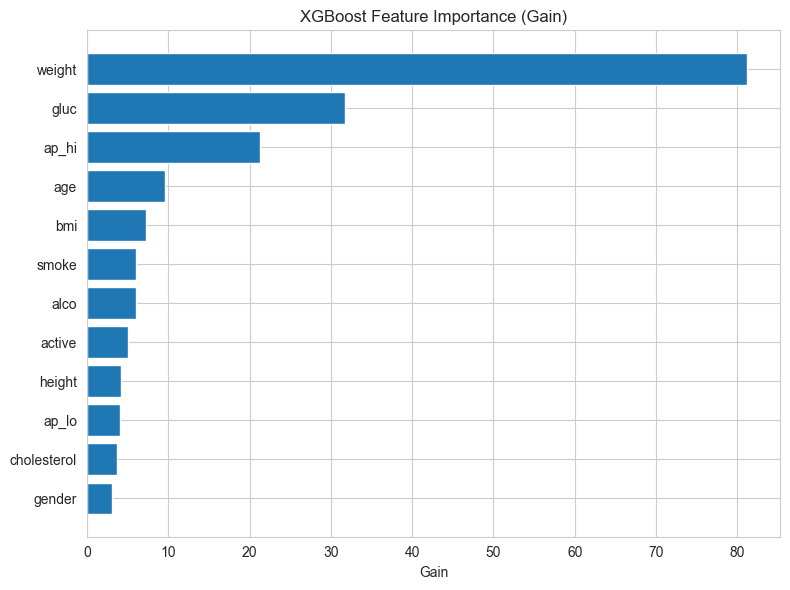

In [32]:
plt.figure(figsize=(8, 6))
plt.barh(
    importance_df["feature_name"],
    importance_df["gain"]
)
plt.gca().invert_yaxis()
plt.xlabel("Gain")
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()


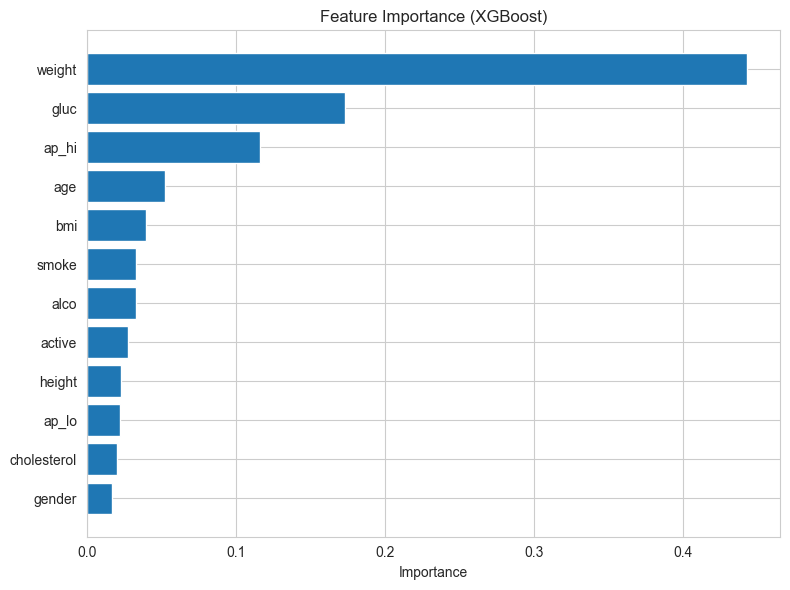

In [33]:
xgb_model = final_model.named_steps["model"]

importances = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(
    importance_df["feature"],
    importance_df["importance"]
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()


In [34]:

bins = [0.0, 0.20, 0.35, 0.50, 0.70, 1.0]
labels = [
    "Very Low Risk",
    "Low Risk",
    "Moderate Risk",
    "High Risk",
    "Very High Risk"
]

risk_zone = pd.cut(y_prob, bins=bins, labels=labels, include_lowest=True)


In [35]:
counts = risk_zone.value_counts()
percentages = counts / counts.sum() * 100
percentages


Very Low Risk     14.971429
Low Risk          22.185714
Moderate Risk     16.421429
High Risk         14.185714
Very High Risk    32.235714
Name: count, dtype: float64

In [36]:
df_test = X_test.copy()
df_test["y_prob"] = y_prob
df_test["risk_zone"] = risk_zone

df_test.groupby("risk_zone")["y_prob"].agg(["min", "max", "mean"])


C:\Users\Anish Kumar Verma\AppData\Local\Temp\ipykernel_31692\1436468448.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_test.groupby("risk_zone")["y_prob"].agg(["min", "max", "mean"])


,min,max,mean
risk_zone,,,
Very Low Risk,0.013267,0.199926,0.127818
Low Risk,0.200160,0.349956,0.271663
Moderate Risk,0.350088,0.499970,0.417265
High Risk,0.500008,0.699706,0.589012
Very High Risk,0.700012,0.961856,0.832435


In [37]:
import joblib

joblib.dump(grid1.best_estimator_, "models/cardiac_failure_detection.pkl")

['models/cardiac_failure_detection.pkl']